# **Combinatorial MABs**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx # we will use it mostly for visualization
from scipy.optimize import linear_sum_assignment
from scipy.optimize import milp
from scipy import optimize
from scipy.sparse.csgraph import shortest_path

## Weighted Matching Problem 

#### We have $S$ workers to allocate among $Q$ tasks.
#### If we assign worker $i$ to task $j$, we obtain reward $w_{ij}$

In [2]:
def plot_weighted_bipartite(W, with_weights=True):
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"
    B.add_nodes_from(np.arange(W.shape[0]), bipartite=0)
    task_labels = [str(i) for i in range(W.shape[1])] # do not repeat labels
    B.add_nodes_from(task_labels, bipartite=1)
    # Add edges only between nodes of opposite node sets
    for (i, j), w in np.ndenumerate(W):
        if w > 0:
            B.add_edge(i, task_labels[j], weight=w)
    pos = nx.drawing.layout.bipartite_layout(B, np.arange(W.shape[0]))
    nx.draw_networkx(B,
                     pos = pos, 
                     width = 2,
                     with_labels = True) # Or whatever other display options you like
    if with_weights:
        edge_labels = nx.get_edge_attributes(B, "weight")
        nx.draw_networkx_edge_labels(B, pos, edge_labels)

def plot_weighted_matching(matching, W, with_zeros=False):
    # matching can be a list of edges or a matrix from that list
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"
    B.add_nodes_from(np.arange(W.shape[0]), bipartite=0)
    task_labels = [str(i) for i in range(W.shape[1])] # do not repeat labels
    B.add_nodes_from(task_labels, bipartite=1)
    # Add edges only between nodes of opposite node sets
    for e in matching:
        i,j = e
        if with_zeros or W[i,j] > 0:
            B.add_edge(i, task_labels[j], weight=W[i,j])
    pos = nx.drawing.layout.bipartite_layout(B, np.arange(W.shape[0]))
    nx.draw_networkx(B,
                     pos = pos, 
                     width = 2,
                     with_labels = True) # Or whatever other display options you like
    edge_labels = nx.get_edge_attributes(B, "weight")
    nx.draw_networkx_edge_labels(B, pos, edge_labels)

### Special case: maximum matching (0/1 weights)

In [3]:
# example from slide 8
W = np.array([[1, 0, 1],
              [0, 1, 0],
              [0, 1, 0]])
W

array([[1, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])

In [5]:
row_ind, col_ind = linear_sum_assignment(W, maximize=True)
matching = list(zip(row_ind, col_ind))
matching

[(np.int64(0), np.int64(0)),
 (np.int64(1), np.int64(1)),
 (np.int64(2), np.int64(2))]

### Non balanced matching

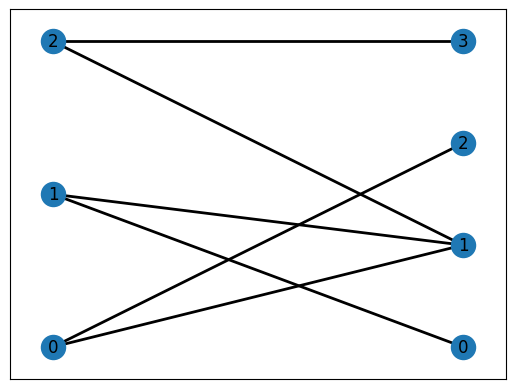

In [10]:
W = np.array([[0,1,1,0],
              [1,1,0,0],
              [0,1,0,1]])
plot_weighted_bipartite(W, with_weights=False)

Value: 3


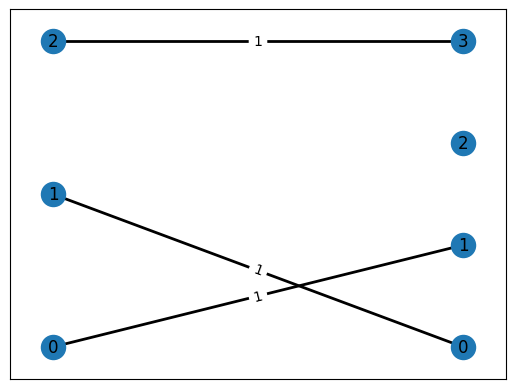

In [11]:
row_ind, col_ind = linear_sum_assignment(W, maximize=True)
matching = list(zip(row_ind, col_ind))
plot_weighted_matching(matching, W)
print(f'Value: {np.sum(W[row_ind,col_ind])}')

#### Most algorithms are designed for a balanced problem ($|S|=|Q|$)
#### You can balance the problem by adding dummy nodes

array([[0., 1., 1., 0.],
       [1., 1., 0., 0.],
       [0., 1., 0., 1.],
       [0., 0., 0., 0.]])

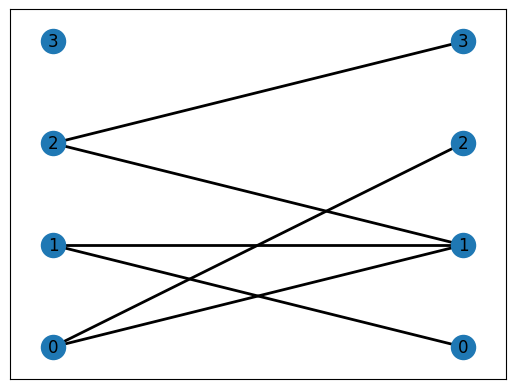

In [12]:
to_add = np.zeros((W.shape[1] - W.shape[0], W.shape[1]))
W_balanced = np.concatenate([W,to_add],axis=0)
plot_weighted_bipartite(W_balanced, with_weights=False)
W_balanced 

## Combinatorial bandits with matching constraint

#### We consider a bernoulli-enviroment: $w_{i,j}$ is the probability that worker $i$ complete tasks j.

In [13]:
class BernoulliMatchingEnv:
    def __init__(self, W, T):
        self.W = W
        # we can generate the realization in advance
        self.realizations = np.zeros((T,W.shape[0],W.shape[1]))
        for (i,j), p in np.ndenumerate(W):
            self.realizations[:,i,j] = np.random.binomial(n=1,p=p, size=T)
        self.t = 0
    
    def round(self, matching):
        # mathcing is a list of tuples (edges)
        # obs: the implementation is a bit inefficient
        # because we convert from two list to single list and then to double lists again,
        # but the single list of pairs is the most "intuitive" representation
        agents, tasks = list(zip(*matching))
        W_t = self.realizations[self.t]
        rewards = W_t[agents,tasks]
        self.t += 1
        return rewards # list of rewards (one for each edge of matching)


## Combinatorial UCB
- #### build an UCB for each arm
- #### the UCB of a superarm is the sum of the UCBs of its components
- #### play the super arm with the highest UCB


In [ ]:
# We assume that every agent can complete every task (all edges exist)
class UCBMatchingAgent:
    def __init__(self, n_workers, n_tasks, T):
        self.W_avg = np.zeros((n_workers,n_tasks))
        self.N_pulls = np.zeros((n_workers,n_tasks))
        self.T = T # not strictly necessary, you can use the anytime version of UCB
        self.t = 0
        self.A_t = None
        self.rows_t = None
        self.cols_t = None
    
    def pull_arm(self):
        # if an arm is unexplored, then the UCB is a large value
        W = np.zeros(self.W_avg.shape, dtype=float)
        large_value = (1 + np.sqrt(2*np.log(self.T)/1))*10
        W[self.N_pulls==0] = large_value
        mask = self.N_pulls>0
        W[mask] = self.W_avg[mask] + np.sqrt(2*np.log(self.T)/self.N_pulls[mask])
        self.rows_t, self.cols_t = linear_sum_assignment(W, maximize=True)
        self.A_t = list(zip(self.rows_t, self.cols_t))
        return self.A_t

    def update(self, rewards):
        self.N_pulls[self.rows_t, self.cols_t] += 1
        self.W_avg[self.rows_t, self.cols_t] += (rewards - self.W_avg[self.rows_t, self.cols_t])/self.N_pulls[self.rows_t, self.cols_t]
        self.t += 1

#### First we test it on a non-combinatorial setting

In [17]:
W = np.array([[0.1,0.5,0.7,0.3]]) # a superarm is a single arm
clairvoyant_rows, clairvoyant_cols = linear_sum_assignment(W, maximize=True)
clairvoyant_matching = list(zip(clairvoyant_rows,clairvoyant_cols))
expected_clairvoyant_reward = np.sum(W[clairvoyant_rows, clairvoyant_cols])

T = 2000

regret_per_trial = []
pulls_per_trial = []
n_trials = 20

np.random.seed(32)
for _ in range(n_trials):
    env = BernoulliMatchingEnv(W, T)
    agent = UCBMatchingAgent(W.shape[0], W.shape[1], T)

    agent_rewards = np.array([])
    agent_pulls = np.zeros(W.shape[1])

    for t in range(T):
        A_t = agent.pull_arm()
        rewards_t = env.round(A_t)
        agent.update(rewards_t)

        agent_rewards = np.append(agent_rewards, np.sum(rewards_t))
        agent_pulls[A_t[0][1]] += 1

    cumulative_regret = np.cumsum(expected_clairvoyant_reward-agent_rewards)
    regret_per_trial.append(cumulative_regret)
    pulls_per_trial.append(agent_pulls)

regret_per_trial = np.array(regret_per_trial)
pulls_per_trial = np.array(pulls_per_trial)

avg_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

avg_pulls = pulls_per_trial.mean(axis=0)

In [18]:
avg_pulls

array([  30.85,  188.85, 1716.45,   63.85])

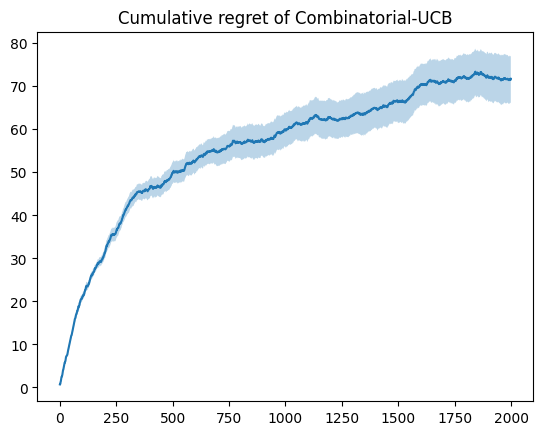

In [19]:
plt.plot(np.arange(T), avg_regret, label='Average Regret')
plt.title('Cumulative regret of Combinatorial-UCB')
plt.fill_between(np.arange(T),
                avg_regret-regret_sd/np.sqrt(n_trials),
                avg_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.show()

### Now a combinatorial setting

In [ ]:
W = np.array([[0.1,0.3,0.7,0.1],
              [0.3,0.8,0.2,0.3],
              [0.5,0.7,0.1,0.9],
              [0.8,0.2,0.5,0.7]])
clairvoyant_rows, clairvoyant_cols = linear_sum_assignment(W, maximize=True)
clairvoyant_matching = list(zip(clairvoyant_rows,clairvoyant_cols))
expected_clairvoyant_reward = np.sum(W[clairvoyant_rows, clairvoyant_cols])

T = 3000 

regret_per_trial = []
n_trials = 20

np.random.seed(32)
for _ in range(n_trials):
    env = BernoulliMatchingEnv(W, T)
    agent = UCBMatchingAgent(W.shape[0], W.shape[1], T)

    agent_rewards = np.array([])
    agent_superarms = []

    for t in range(T):
        A_t = agent.pull_arm()
        rewards_t = env.round(A_t)
        agent.update(rewards_t)

        agent_rewards = np.append(agent_rewards, np.sum(rewards_t))
        agent_superarms.append(A_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_reward-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

avg_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

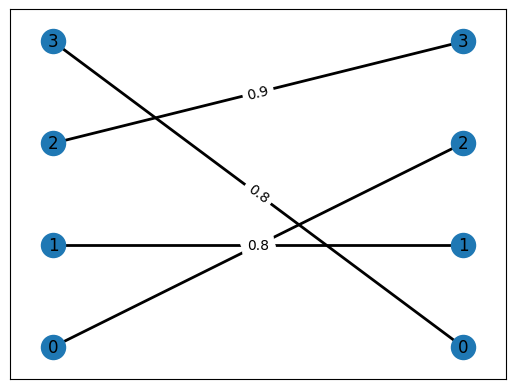

In [25]:
plot_weighted_matching(clairvoyant_matching, W)

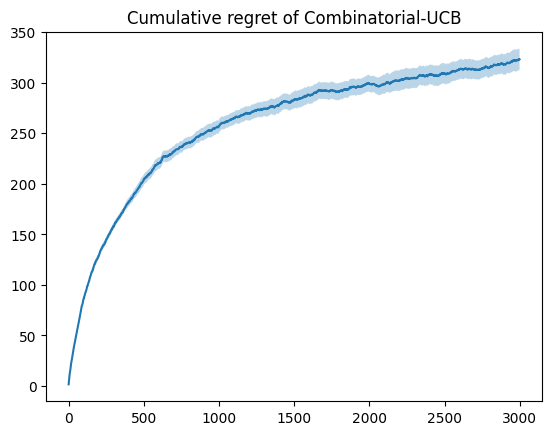

In [26]:
plt.plot(np.arange(T), avg_regret, label='Average Regret')
plt.title('Cumulative regret of Combinatorial-UCB')
plt.fill_between(np.arange(T),
                avg_regret-regret_sd/np.sqrt(n_trials),
                avg_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.show()

## Online Knapsack

- #### Capacity $C$
- #### Each arm $a$ has a **non-stochastic and known** size $s_a$
- #### We can plays superarms that do not exceed the capaicty
- #### Each arm is associated with a reward distribution

#### It can be seen as a problem with workers and tasks: 
- #### there are $C$ workers and they are all equivalent
- #### There are $K$ tasks, task $a$ requires $s_a$ workers to be executed and provides an unknown stochastic reward

#### **Remark**: this is **not** the budget constraint of the previous lectures

#### First we solve the offline problem (clairvoyant)

In [31]:
C = 10
s = np.array([3,  4, 5, 6, 7, 8])
mu = np.array([2, 3, 3, 5, 4, 7])
K = len(s)
mu/s, np.argsort(-mu/s)

(array([0.66666667, 0.75      , 0.6       , 0.83333333, 0.57142857,
        0.875     ]),
 array([5, 3, 1, 0, 2, 4]))

#### One possibility is to cast the problem as a MILP:
$$ \max_x \sum_a \mu_a x_a  \\ s.t. \sum_a s_a x_a \le C \\ \;\;\;\;\;\;\;\; x_a \in \{0,1\} \; \forall a$$

#### See also: https://docs.scipy.org/doc/scipy/tutorial/optimize.html#knapsack-problem-example



In [32]:
bounds = optimize.Bounds(0, 1)  # 0 <= x_a <= 1
integrality = np.ones(K)  # 1 in position a means that x_a is integer
constraints = optimize.LinearConstraint(A=s, lb=0, ub=C)
res = milp(c=-mu, constraints=constraints, integrality=integrality, bounds=bounds) #it minimizes
res.success, res.fun, res.x

(True, -8.0, array([0., 1., 0., 1., 0., 0.]))

In [33]:
# this is not the greedy solution:
mu/s, np.argsort(-mu/s)

(array([0.66666667, 0.75      , 0.6       , 0.83333333, 0.57142857,
        0.875     ]),
 array([5, 3, 1, 0, 2, 4]))

In [34]:
# let's write a resuable function
def solve_knapsack_milp(v, s, C):
    bounds = optimize.Bounds(0, 1)  # 0 <= x_a <= 1
    integrality = np.ones(len(v))  # 1 in position a means that x_a is integer
    constraints = optimize.LinearConstraint(A=s, lb=0, ub=C)
    res = milp(c=-v, constraints=constraints, integrality=integrality, bounds=bounds) #it minimizes
    return np.arange(len(v))[res.x > 0.5]
    # be careful: even if we impose the integrality constraint
    # milp can return something that is not exactly 1 (e.g. 1.000000007)
    # so do not use np.arange(len(v))[res.x == 1]
    # becasue sometimes it does not work

In [35]:
items = solve_knapsack_milp(mu, s, C)
print(f'items:{items}, value:{np.sum(mu[items])}')

items:[1 3], value:8


#### Another possibility is to use dynamic programming
#### Let $M(n,c)$ be the optimal value given capacity $c \le C$ and only the first $n$ items
#### $$M(n,c) = \max \{M(n-1,c), \mu_n +M(n-1,c-s_n)\} $$
#### with: 
- #### $M(n-1,c) = 0$ if $n-1 \le 0$ and $c \ge 0$
- #### $M(n-1,c-s_n) = -\infty$ if $c-s_n <0$

In [36]:
def solve_knapsack_dynamic(v, s, C):
    M = np.zeros((len(s),C+1)) # optimal values
    A = np.zeros((len(s),C+1)) # whether item n is added or not
    for n in range(len(s)):
        for c in range(C+1):
            M[n,c], A[n,c] = solve_knapsack_cell(v, s, n, c, M)
    
    items = []
    c = C
    for n in range(len(v)-1, -1, -1):
        if A[n,c] == 1:
            items.append(n)
            c = c - s[n]
    return items         

def solve_knapsack_cell(v, s, n, c, M):
    value_no_n = M[n-1,c] if n > 0 else 0 
    if s[n] > c:
        return value_no_n, 0
    value_with_n = v[n] + M[n-1, c-s[n]] if n>0 else v[n]
    if value_no_n > value_with_n:
        return value_no_n, 0
    return value_with_n, 1

In [37]:
items = solve_knapsack_dynamic(mu, s, C)
print(f'items:{items}, value:{np.sum(mu[items])}')

items:[3, 1], value:8


#### Now the online learning problem

In [38]:
class GaussianKnapsackEnv:
    def __init__(self, mu, s, T):
        self.mu = mu
        self.s = s
        # we can generate the realization in advance
        self.rewards = np.random.normal(mu, 1, size=(T,len(mu)))
        self.t = 0
    
    def round(self, A_t):
        return self.rewards[t,A_t]

In [39]:
env = GaussianKnapsackEnv(mu, s, 3000)
env.round([0,3])

array([1.31346062, 6.14126227])

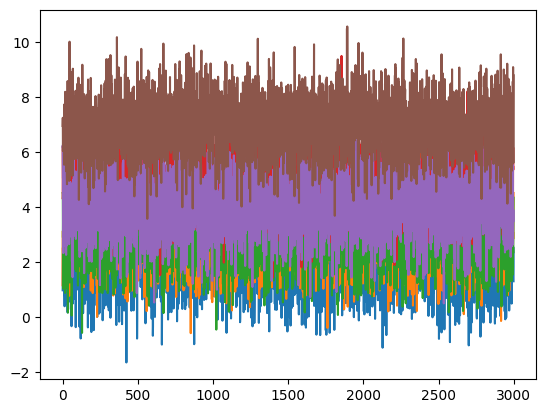

In [40]:
for a in range(len(mu)):
    plt.plot(env.rewards[:,a])

In [41]:
# for simplicty, we assume that every agent can complete every task (all edges exist)
class UCBKnapsackAgent:
    def __init__(self, s, C, T, solver, range=1):
        self.avgs = np.zeros(len(s))
        self.N_pulls = np.zeros(len(s))
        self.K = len(s)
        self.s = s
        self.C = C
        self.T = T # not strictly necessary, you can use the anytime version of UCB
        self.solver = solver
        self.range = range
        self.t = 0
        # logging
        self.A_t = None
        self.ucbs = []
    
    def pull_arm(self):
        if np.min(self.N_pulls) == 0:
            # dummy knapsack problem to pull non-pulled arms
            values = np.ones(self.K)
            sizes = np.copy(self.s)
            sizes[self.N_pulls > 0] = self.C + 1
        else:
            values = self.avgs + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls) #UCBs
            sizes = self.s
        self.A_t = self.solver(values, sizes, self.C)
        self.ucbs.append(values) # ok, the intial ones are not the true UCBs
        return self.A_t

    def update(self, rewards):
        self.N_pulls[self.A_t] += 1
        self.avgs[self.A_t] += (rewards - self.avgs[self.A_t])/self.N_pulls[self.A_t]
        self.t += 1

In [42]:
C = 10
s = np.array([3,  4, 5, 6, 7, 8])
mu = np.array([2, 3, 3, 5, 4, 7])
clairvoyant_superarm = solve_knapsack_dynamic(mu, s, C)
expected_clairvoyant_reward = np.sum(mu[clairvoyant_superarm])

T = 3000
T = 5000

regret_per_trial = []
n_trials = 30
n_trials = 100

# np.random.seed(32)
for seed in range(n_trials):
    np.random.seed(seed)
    env = GaussianKnapsackEnv(mu, s, T)
    agent = UCBKnapsackAgent(s, C, T, solve_knapsack_dynamic)

    agent_rewards = np.array([])

    for t in range(T):
        A_t = agent.pull_arm()
        rewards_t = env.round(A_t)
        agent.update(rewards_t)

        agent_rewards = np.append(agent_rewards, np.sum(rewards_t))

    cumulative_regret = np.cumsum(expected_clairvoyant_reward-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

avg_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

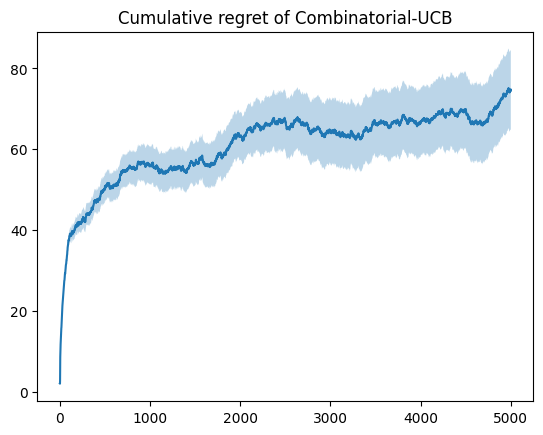

In [43]:
plt.plot(np.arange(T), avg_regret, label='Average Regret')
plt.title('Cumulative regret of Combinatorial-UCB')
plt.fill_between(np.arange(T),
                avg_regret-regret_sd/np.sqrt(n_trials),
                avg_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.show()